# Sample data Exploration Data Analysis & Further Cleaning
### Since we randomly sampled from the original dataset, it's OK to do EDA in sampled datasets( from spark to pandas). This is done after built up first model

### 1. sample_play
Mainly for play_time/song_length

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
#1.Load in sample_play
##notice the type of variables
colname = ['uid', 'device', 'song_id', 'play_time', 'song_length', 'date', 'Churn']
datatype = {'uid': 'int64', 'device': 'object', 'song_id': 'float64', 'song_length': 'float64', 'date':'object', 'Churn': 'int64'}
sample_play = pd.read_csv("D:/MusicFile/sample_play_316.csv", header = 0, dtype = datatype, names = colname)

In [3]:
#check variable types
sample_play['date'] = pd.to_datetime(sample_play['date'])
print(sample_play.dtypes)

sample_play.sample(8)

uid                     int64
device                 object
song_id               float64
play_time             float64
song_length           float64
date           datetime64[ns]
Churn                   int64
dtype: object


,uid,device,song_id,play_time,song_length,date,Churn
4879194,168519424,ar,1575088.0,5.0,275.0,2017-04-08,0
628184,168818752,ar,0.0,14.0,154.0,2017-04-04,0
1502147,154595776,ar,3213921.0,263.0,263.0,2017-03-09,1
4166495,167917008,ip,437869.0,229.0,229.0,2017-04-09,0
3711529,168560560,ar,435280.0,183.0,284.0,2017-04-04,0
4462629,167681200,ar,9823138.0,4.0,111.0,2017-04-02,0
750716,94891472,ar,626047.0,0.0,308.0,2017-03-30,0
4177734,168924832,ip,6916106.0,78.0,236.0,2017-04-06,0


In [18]:
#check whether each record records single play or cumulative play
sample_play.groupby(['uid', 'song_id', 'date']).head()
sample_play[['uid', 'song_id', 'date']][((sample_play.uid ==49423096)&(sample_play.song_id==4348548.0))|((sample_play.uid == 168915904)&(sample_play.song_id == 6611804.0))]

,uid,song_id,date
24,49423096,4348548.0,2017-04-05
25,49423096,4348548.0,2017-04-05
77,49423096,4348548.0,2017-04-06
78,49423096,4348548.0,2017-04-06
151,49423096,4348548.0,2017-04-07
4955453,168915904,6611804.0,2017-04-27
4955454,168915904,6611804.0,2017-04-27


Here, we can see that in same date, there are multiple records for same uid and same song_id, which enables me to make assumption as follows.
**In spark, I only did roughly filter/impute of play_time and song_length, if just leave those data to feature generation, there might be difficult to create features about play_completition, so it's better to clean play_time and song_length... based on heuristic knowledge** 

My cleaning principle is: 

**Assumption**: each record only record one play time(not cumulative), if user play one song iteratively, the records will show multiple records, thus play_time should be ≤ song_length

**play_time**:
- if >10E5(only (20/4235452) no sense)(user = 17) or play_time == 0(user skipped play or clicked by error), drop them(user = 8)
- if >10E4, devided by 1000. Since it's possible play_time was recorded as miliseconds
- if > song_length, check its correctness, impute by the above way or song_length-1

**song_length**:
- if >10E6(no sense) or = 0, impute with play_time this step is done in Spark; by later check, find there is no song_length >10E4, which means existed song_length are reasonable, and imputed song_length has reasonable play_time. Play_time can be derived by song_length

**[Notice]song_id**:
- song_id ==0, with multiple song_length and play_time by different users, which means it's not a unique song, it's happened possibly due to mislocation of song_type(with value=0,1,2). There are nearly 10%(346692/4235452) of song_id =0. It's OK to just leave them as original, since we are now doing Churn prediction. However, if we want to do song_recommendation in the future, we should find better way to impute them. 
- song_id = -1(177/4235452), with 9 users. Also keep. 

#### 1.1 play_time & song_length

In [21]:
print("play_time >10E5:", sample_play.play_time[(sample_play.play_time>10E5)].count())
print("song_length>10E3", sample_play.play_time[(sample_play.song_length>10E3)].count())
print("check how many play_time > song_length and:")
print("play_time >10E5:", sample_play.play_time[(sample_play.play_time>10E5)&(sample_play.play_time>sample_play.song_length)].count())
print("play_time ∈(10E4, 10E5):", sample_play.song_length[((sample_play.play_time>10E4)&(sample_play.play_time<10E5))&(sample_play.play_time>sample_play.song_length)].count())
print("play_time ∈(10E3, 10E4):", sample_play.song_length[((sample_play.play_time>10E3)&(sample_play.play_time<10E4))&(sample_play.play_time>sample_play.song_length)].count())
print("play_time ∈(10E2, 10E3):", sample_play.song_length[((sample_play.play_time>10E2)&(sample_play.play_time<10E3))&(sample_play.play_time>sample_play.song_length)].count())
print("Check how many users have incorrect ")
print("play_time >10E5:",sample_play.uid[sample_play.play_time[(sample_play.play_time>10E5)&(sample_play.play_time>sample_play.song_length)]].value_counts().shape[0])
print("play_time ∈(10E4, 10E5):",sample_play.uid[sample_play.song_length[((sample_play.play_time>10E4)&(sample_play.play_time<10E5))&(sample_play.play_time>sample_play.song_length)]].value_counts().shape[0])
print("play_time ∈(10E3, 10E4):",sample_play.uid[sample_play.song_length[((sample_play.play_time>10E3)&(sample_play.play_time<10E4))&(sample_play.play_time>sample_play.song_length)]].value_counts().shape[0])
print("play_time ∈(10E2, 10E3):",sample_play.uid[sample_play.song_length[((sample_play.play_time>10E2)&(sample_play.play_time<10E3))&(sample_play.play_time>sample_play.song_length)]].value_counts().shape[0])


play_time >10E5: 0
song_length>10E3 62
check how many play_time > song_length and:
play_time >10E5: 0
play_time ∈(10E4, 10E5): 28147
play_time ∈(10E3, 10E4): 7789
play_time ∈(10E2, 10E3): 6850
Check how many users have incorrect 
play_time >10E5: 0
play_time ∈(10E4, 10E5): 15
play_time ∈(10E3, 10E4): 15
play_time ∈(10E2, 10E3): 18


In [4]:
#filter sample_play by play_time and song_length
#by play_time
sample_play = sample_play[sample_play.play_time < 10E5]
sample_play = sample_play[0<sample_play.play_time] 
#by song_Length

In [ ]:
#first convert song_length from float to int
#sample_play.song_length = sample_play.song_length.astype(int)
#len(str(sample_play.song_length[sample_play.iloc]))


#sample_play['song_dig'] = sample_play['song_length'].apply(lambda x: len(str(x)))
#sample_play['adjust_play_time'] = sample_play.apply(lambda x: x['play_time'][: x['song_dig']], axis = 1)
###that's what I want to do, but couldn't because of Memory error!!!!
#truncate play_time to len(song_length) if play_time >song_length
#sample_play['adjust_play_time'] = sample_play.play_time.apply(lambda x: x[:])
'''
def trunc(df):
    if df.play_time > df.song_length:
        l = len(str(df.song_length))
        df.play_time = df.play_time[:l]
    else:
        df.play_time = df.play_time
    return df.play_time
    '''

In [5]:
#convert miliseconds => seconds
sample_play['adjust_play_time'] = np.where(sample_play['play_time'] > 10E4, (sample_play['play_time']/1000).astype(int), sample_play['play_time'])

In [6]:
#after milisecond=>seconds
print("check how many play_time > song_length and:")
print("adjust_play_time >10E4:", sample_play.play_time[(sample_play.adjust_play_time>10E4)&(sample_play.adjust_play_time>sample_play.song_length)].count())
print("adjust_play_time ∈(10E2, 10E4):", sample_play.song_length[((sample_play.adjust_play_time>10E2)&(sample_play.adjust_play_time<10E4))&(sample_play.adjust_play_time>sample_play.song_length)].count())

print("Check how many users have incorrect ")
print("adjust_play_time >10E4:",sample_play.uid[sample_play.play_time[(sample_play.adjust_play_time>10E4)&(sample_play.adjust_play_time>sample_play.song_length)]].value_counts().shape[0])
print("adjust_play_time ∈(10E2, 10E4):",sample_play.uid[sample_play.song_length[((sample_play.adjust_play_time>10E2)&(sample_play.adjust_play_time<10E4))&(sample_play.adjust_play_time>sample_play.song_length)]].value_counts().shape[0])
print("adjust_play_time>song_length:",len(sample_play.uid[sample_play.adjust_play_time>sample_play.song_length].unique()))

check how many play_time > song_length and:
adjust_play_time >10E4: 0
adjust_play_time ∈(10E2, 10E4): 14639
Check how many users have incorrect 
adjust_play_time >10E4: 0
adjust_play_time ∈(10E2, 10E4): 18
adjust_play_time>song_length: 7059


In [10]:
sample_play[(sample_play.adjust_play_time>sample_play.song_length)&((sample_play.adjust_play_time>10E3)&(sample_play.adjust_play_time<10E5))].sample(10)

,uid,device,song_id,play_time,song_length,date,Churn,adjust_play_time
3403784,167803488,ar,856673.0,26030.0,114.0,2017-04-13,0,26030.0
3559716,168073296,ar,294622.0,20434.0,351.0,2017-04-28,0,20434.0
2537927,167583760,ar,23495222.0,36502.0,320.0,2017-04-04,0,36502.0
1328407,168284048,ar,359861.0,53340.0,207.0,2017-04-01,0,53340.0
1062710,167605664,ar,23529236.0,30669.0,139.0,2017-04-03,0,30669.0
4762532,167945200,ar,708072.0,86378.0,326.0,2017-04-02,0,86378.0
3515419,168685696,ar,158864.0,93015.0,276.0,2017-04-04,0,93015.0
1458018,159405616,ar,23037386.0,59257.0,251.0,2017-04-09,0,59257.0
3671391,154600016,ar,6358424.0,17335.0,241.0,2017-03-01,1,17335.0
1162953,168643024,ar,858008.0,17987.0,93.0,2017-04-18,1,17987.0


After convert, Only 18 users have adjust play time ∈(10E2, 10E4), but 7059 users have adjust_play_time>song_length. By checking, find there are situations that not make too much sense...but we do notcie there are play_time: 58614 with song_length 59, play_time:99938 with song_length 100/ play_time:12075 with song_length 245/play_time:73933 with song_length 123. For the last two situation, It's kind of difficult to impute without further information. 

Thus, in order to impute all these three conditions, impute incorrect play_time with song_length -1

In [6]:
sample_play['adjust_play_time'] = np.where(sample_play.adjust_play_time>sample_play.song_length,sample_play.song_length-1, sample_play.adjust_play_time)
sample_play[(sample_play.play_time>sample_play.song_length)].sample(8)

,uid,device,song_id,play_time,song_length,date,Churn,adjust_play_time
2884338,168571440,ar,7010204.0,66.0,65.0,2017-03-31,0,64.0
4550605,154438112,ar,15195572.0,255.0,125.0,2017-03-06,1,124.0
1066751,168364880,ar,4859593.0,267.0,266.0,2017-04-09,0,265.0
3356699,167616208,ar,23498554.0,229878.0,230.0,2017-03-31,1,229.0
1029956,154586096,ar,985258.0,194.0,193.0,2017-03-02,1,192.0
750908,94891472,ar,125223.0,255.0,254.0,2017-04-02,0,253.0
707005,82485712,ar,23375964.0,184.0,183.0,2017-04-18,0,182.0
1834626,168789792,ar,0.0,6.0,4.0,2017-03-31,1,3.0


In [7]:
#do not save row index
sample_play.to_csv("D:/MusicFile/sample_play_318.csv", header = True, index = False)

In [32]:
sample_play[['adjust_play_time', 'song_length']].describe()

,adjust_play_time,song_length
count,4.235432e+06,4.235432e+06
mean,1.734569e+02,2.635448e+02
std,1.849254e+02,2.850556e+02
min,0.000000e+00,1.000000e+00
25%,4.500000e+01,2.060000e+02
50%,1.930000e+02,2.430000e+02
75%,2.520000e+02,2.800000e+02
max,4.189700e+04,6.685100e+04


#### 1.2 Plot sample_play

In [2]:
datatype = {'uid': 'int64', 'device': 'object', 'song_id': 'float64', 'song_length': 'float64', 'date':'object', 'Churn': 'int64', 'adjust_play_time':'float64'}
#colname = []
sample_play = pd.read_csv("D:/MusicFile/sample_play_318.csv", header = 0, dtype = datatype, index_col = 0)

c:\users\tianyi fang\appdata\local\programs\python\python36-32\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
sample_play['date'] = pd.to_datetime(sample_play['date'])
print(sample_play.dtypes)
sample_play.sample(8)

song_id                    float64
song_length                float64
date                datetime64[ns]
Churn                        int64
adjust_play_time           float64
device                      object
dtype: object


,song_id,song_length,date,Churn,adjust_play_time,device
uid,,,,,,
169022784,3345090.0,240.0,2017-04-02,0,239.0,both
168126384,708770.0,265.0,2017-04-15,0,265.0,ar
154785136,125802.0,241.0,2017-03-05,1,9.0,both
154466784,20273752.0,225.0,2017-03-06,1,224.0,ar
168518208,20674552.0,286.0,2017-04-21,0,286.0,both
167646512,82445.0,271.0,2017-04-04,0,270.0,ar
168611904,505795.0,286.0,2017-04-04,0,286.0,both
168246336,1566133.0,288.0,2017-04-12,0,288.0,ar


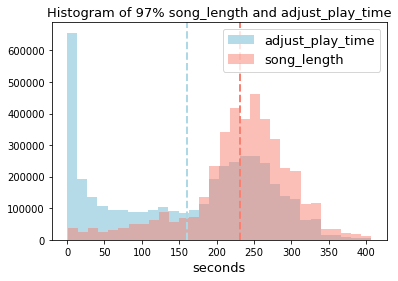

In [5]:
q97 = sample_play[['adjust_play_time', 'song_length']][sample_play['song_length']<sample_play['song_length'].quantile(0.97)]
q97 = pd.DataFrame(q97)
fig, ax = plt.subplots()

ax.hist(q97['adjust_play_time'], bins =30, alpha = 0.9, color = 'lightblue')
ax.hist(q97['song_length'], bins =30, alpha = 0.5, color = 'salmon')
plt.axvline(q97['adjust_play_time'].mean(), color='lightblue', linestyle='dashed', linewidth=2)
plt.axvline(q97['song_length'].mean(), color='salmon', linestyle='dashed', linewidth=2)
plt.title('Histogram of 97% song_length and adjust_play_time' , fontsize = 13)
plt.xlabel("seconds", fontsize = 13)
plt.legend(loc='upper right', fontsize = 13)

In [14]:
sample_play_d = sample_play.copy()
sample_play_d.reset_index(inplace = True)
sample_play_d.head()

,uid,song_id,song_length,date,Churn,adjust_play_time,device
0,49423096,203139.0,270.0,2017-04-02,0,204.0,ar
1,49423096,133946.0,286.0,2017-04-02,0,165.0,ar
2,49423096,380389.0,233.0,2017-04-02,0,40.0,ar
3,49423096,23534240.0,378.0,2017-04-02,0,115.0,ar
4,49423096,6672344.0,249.0,2017-04-02,0,69.0,ar


In [15]:
#check device
device_count = sample_play_d[['uid', 'device']].drop_duplicates() \
                                              .groupby('uid')['device'] \
                                              .agg(['max', 'count'])
device_count['device'] = np.where(device_count['count'] == 1, device_count['max'], 'both')

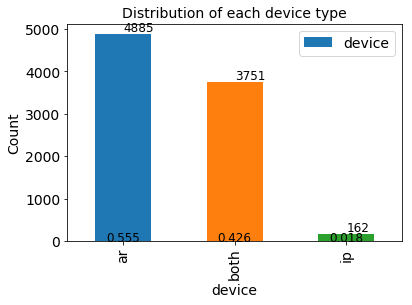

In [23]:

fig = plt.figure()
ax = fig.add_subplot(111)
dc = device_count['device'].value_counts()
dcsum = dc.sum()
dc.plot(kind = 'bar', ax= ax)
plt.title('Distribution of each device type' , fontsize = 14)
plt.xlabel("device", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
plt.xticks( fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(loc='upper right', fontsize = 14)
for i,v in dc.reset_index().iterrows():
    ax.text(i,v['device']+1, v['device'],ha='left', va='bottom', fontsize = 12)
    ax.text(i,(v['device']/dcsum).round(3) + 1, (v['device']/dcsum).round(3),ha='center',fontsize = 12)

            adjust_play_time  song_length
date                                     
2017-03-01        127.220898   259.168609
2017-03-02        164.391645   263.297592
2017-03-03        171.543604   265.285909
2017-03-04        174.524416   267.063617
2017-03-05        178.442732   265.346159


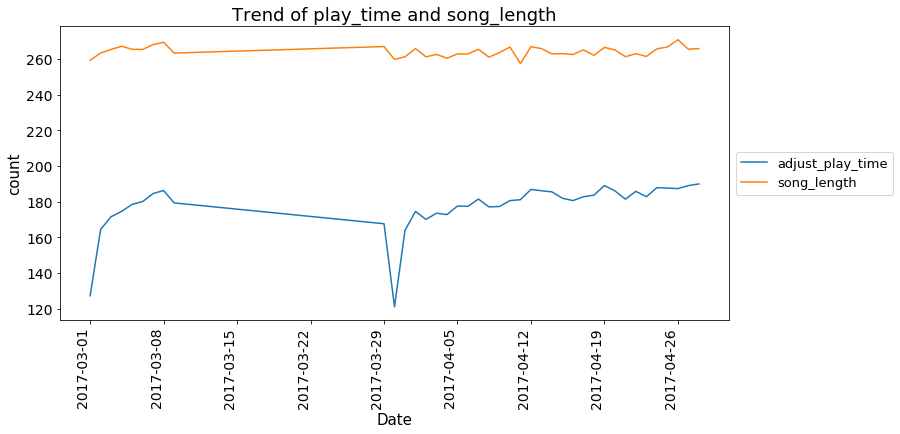

In [44]:
#play_time trend
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
gb = sample_play.groupby(['date'])[['adjust_play_time','song_length']].mean()
#gb['count']= sample_play['date'].value_counts()
gb.plot(kind = 'line', ax = ax)
plt.title('Trend of play_time and song_length', fontsize = 18)
plt.xlabel('Date', fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.ylabel('count', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 13)
print(gb.head())

In [7]:
device_count.reset_index(inplace = True)
print(device_count.dtypes)
device_count.sample(8)

index      int64
uid        int64
max       object
count      int64
device    object
dtype: object


,index,uid,max,count,device
393,393,109958960,ar,1,ar
427,427,118366104,ar,1,ar
4859,4859,167856400,ar,1,ar
8743,8743,169052448,ip,1,ip
958,958,154413392,ip,2,both
3959,3959,167599616,ar,1,ar
98,98,28055436,ar,1,ar
3198,3198,155084816,ip,1,ip


In [8]:
device_df = device_count.drop('max',1).drop('count',1).drop('index',1)
device_df.sample(8)

,uid,device
1595,154532160,both
3898,167583216,ar
6621,168399952,ar
2765,154766544,both
8733,169041984,both
8231,168887056,both
2898,154791456,ar
3960,167599792,ar


In [14]:
#sample_play_d = sample_play.merge(device_df, on = 'uid', how = 'left')
sample_play_d = sample_play_d.drop('device_x',1).rename(columns = {'device_y':'device'})
#sample_play_d = sample_play_d.rename(columns = {'device_y':'device'})
sample_play_d.sample(8)
#sample_play.groupby(['date','device'])[['adjust_play_time','song_length']].mean()

,uid,song_id,play_time,song_length,date,Churn,adjust_play_time,device
4127917,168288096,234717.0,240.0,267.0,2017-04-14,0,240.0,both
1438091,168599568,6506486.0,264.0,264.0,2017-04-07,0,264.0,both
405289,167887840,5885319.0,307.0,308.0,2017-04-18,0,307.0,ar
3949566,168353312,5835282.0,411.0,410.0,2017-04-11,0,409.0,both
2860225,168367200,55219.0,6.0,297.0,2017-04-07,0,6.0,both
204283,168199440,130594.0,268.0,268.0,2017-04-09,0,268.0,both
2036125,168618464,688056.0,244.0,245.0,2017-04-07,0,244.0,both
2684201,168531536,914649.0,283.0,283.0,2017-03-31,0,283.0,both


In [24]:
sample_play_d.shape

(4235432, 8)

In [26]:
#do not save row index
sample_play_d = sample_play_d.drop('play_time', 1)
sample_play_d.to_csv("D:/MusicFile/sample_play_318.csv", header = True, index = False)

In [27]:
sample_play_d.columns

Index(['uid', 'song_id', 'song_length', 'date', 'Churn', 'adjust_play_time',
       'device'],
      dtype='object')

device              ar        both          ip
date                                          
2017-03-01  130.878785  125.045935   72.373057
2017-03-02  166.203492  164.563062   77.137253
2017-03-03  176.045742  170.447218   88.071762
2017-03-04  185.640174  168.831684  122.649772
2017-03-05  184.642318  174.529049  170.789272


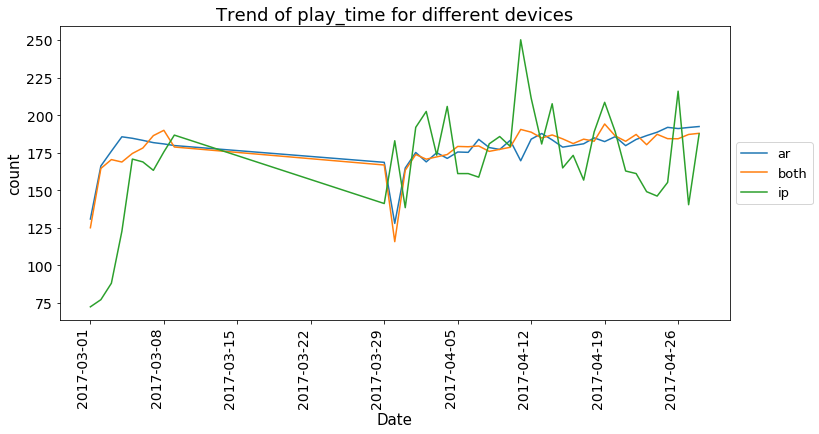

In [23]:
#play_time trend of different devices
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
gb = sample_play_d.groupby(['date','device'])['adjust_play_time'].mean().unstack()
#gb['count']= sample_play['date'].value_counts()
gb.plot(kind = 'line', ax = ax)
plt.title('Trend of average play_time for different devices', fontsize = 18)
plt.xlabel('Date', fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.ylabel('count', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 13)
print(gb.head())

As we can see, even we try to make play_time more sensible by boldly deviding it by either 1000 or 100, but there are still 6660 records(899 users) with adjust_play_time > song_length..It's really difficult to do further imputation without any further information, so I would like to just leave those records.

**Notice** there is song_id ==0(346692/4235452), but with different song_length and different play_time of differnt user, which indicates song_id ==0 is not a unique song, there might be something wrong during record, since the next column is song_type(with value 0,1,2). check if drop song_id ==0, how many uid will be filtered.

#### 1.2 song_id

In [29]:
print("song_id = 0",sample_play.uid[sample_play.song_id ==0].count())
print("song_id = -1",sample_play.uid[sample_play.song_id ==-1].count())


song_id = 0 346692
song_id = -1 177


### Compare with uncleaned:
original rows: 4955455, after cleaning 4235432

original churn rate:4465/4358, after 4464/4334

In [34]:
sample_uid_label_8798 = sample_play_d[['uid','Churn']].drop_duplicates()
sample_uid_label_8798.shape

(8798, 2)

In [35]:
sample_uid_label_8798.to_csv("D:/MusicFile/sample_uid_label8798.csv", header = True, index = False)

## END